In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
import seaborn as sns
import sys

In [31]:
data = pd.read_csv("/Users/veera/Data/Repos/Udemy/.dataset/mnist_train.csv", delimiter=',', header=None)
labels = data[0]
data = data.drop(columns=[0])
data = np.array(data)
labels = np.array(labels)

In [32]:
# The min and max values of the data are 0 and 255
# It is normalized to 0 and 1
data_norm = data/np.max(data)
data_tensor = torch.tensor(data_norm).float()
label_tensor = torch.tensor(labels).long()
data_tensor = data_tensor[:20000]

In [33]:
def model(coders, bottlenecks):
    class aenet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, coders)
            self.enc = nn.Linear(coders, bottlenecks)
            self.latent = nn.Linear(bottlenecks, coders)
            self.dec = nn.Linear(coders, 784)
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.latent(x))
            y = torch.sigmoid(self.dec(x))
            # we want the output in the same range (normalized as 0 to 1 in the previous step) as the input numerical data
            return y
        
    net = aenet()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, loss_function, optimizer
        


In [34]:
def train(nc, nb):
    epochs = 3
    net, loss_function, optimizer = model(nc, nb)
    losses = []
    # implementing minibatches using numpy and pytorch
    batchsize = 32
    n_batches = int(data_tensor.shape[0]/batchsize)
    for i in range(epochs):
        randidx = np.random.permutation(data_tensor.shape[0])
        batch_losses = []
        for j in range(n_batches):
            mini_batch = data_tensor[randidx[j*batchsize:(j+1)*batchsize]]
            x = mini_batch
            yhat = net(x)
            loss = loss_function(yhat, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        losses.append(np.mean(batch_losses[-3:]))
    return losses, net

In [35]:
n_coders = np.linspace(10, 500, 12).astype(int)
n_bnecks = np.linspace(5, 100, 8).astype(int)
results = np.zeros((len(n_coders), len(n_bnecks)))

In [36]:
for ei, nenc in enumerate(n_coders):
    for bi, bneck in enumerate(n_bnecks):
        loss = train(ei, bi)[0]
        results[ei, bi] = np.mean(loss[-5:])
        msg = f"finished: {ei*len(n_bnecks)+bi+1} out of {(len(n_bnecks)*len(n_coders))}"
        sys.stdout.write("\r" + msg)

/Users/veera/Data/Repos/Udemy/.udemy/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


finished: 96 out of 96

In [37]:
results

array([[0.11592063, 0.11547039, 0.11623748, 0.1155315 , 0.11631937,
        0.11526883, 0.11602932, 0.11544582],
       [0.12365929, 0.12575263, 0.12554287, 0.07479692, 0.12396559,
        0.12721401, 0.07331884, 0.12747333],
       [0.12143226, 0.08395843, 0.12111176, 0.08323522, 0.0650294 ,
        0.07144791, 0.12148158, 0.1181875 ],
       [0.12211928, 0.079554  , 0.11930467, 0.07184249, 0.07066895,
        0.07031373, 0.06697437, 0.11824571],
       [0.1158244 , 0.0799185 , 0.06590805, 0.06688946, 0.06646111,
        0.06329931, 0.06266916, 0.06919857],
       [0.11546167, 0.06488796, 0.06640803, 0.07440673, 0.06700864,
        0.06638398, 0.06902903, 0.06718345],
       [0.11815692, 0.07263771, 0.07214924, 0.06911624, 0.06323423,
        0.06322053, 0.06577587, 0.06347412],
       [0.11659896, 0.07031595, 0.06138767, 0.06075213, 0.05995605,
        0.0593991 , 0.06383708, 0.06564764],
       [0.11844464, 0.06535562, 0.07128364, 0.06380036, 0.06241748,
        0.05606963, 0.059497

<Axes: >

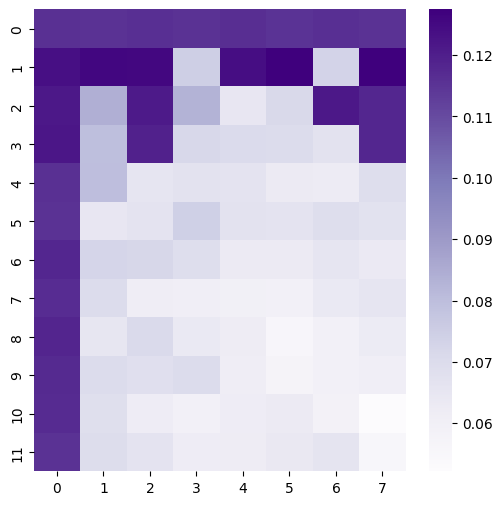

In [38]:
fig = plt.figure(figsize=(6,6))
sns.heatmap(results, cmap='Purples')

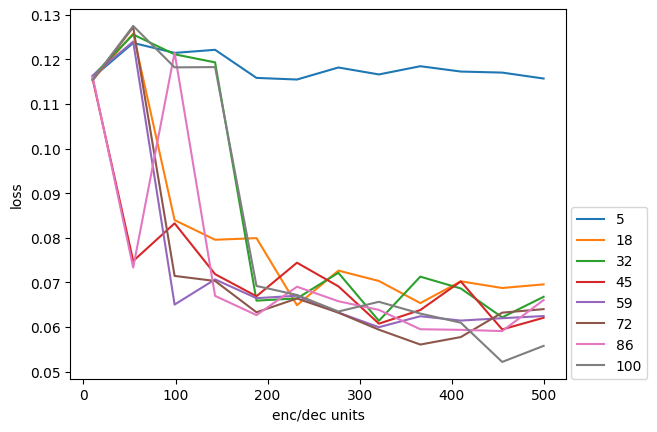

In [39]:
plt.plot(n_coders, results)
plt.legend(n_bnecks, loc=(1.01, 0))
plt.xlabel("enc/dec units")
plt.ylabel("loss")
plt.show()